# Safety First - Hard Hat Detection

---
## Project Proposal

### Team Member

- Stanley Yang
- Lennard Vanderspek 
 
### Description

Workplace safety is very important but often overlooked. Most important way to keep workers 
safe is by wearing a hard hat. This project will utilize Convolution Neural Net and YOLO to help 
detect whether workers are wearing a hard hat or not.

#### Machine Learning Topics Used:

- Convolution Neural Net 
- YOLO 
 
### Expected Outcome

A trained model that is able to detect whether workers are wearing a hard hat or not by 
implementing YOLO using PyTorch. We are hoping to utilize the model to bring more awareness 
to workplace safety.

---

## Use CUDA if Available

In [1]:
import torch

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CUDA is not available.  Training on CPU ...")
else:
    print(f"CUDA is available!  Training on GPU ({torch.cuda.get_device_name(0)}) ...")

CUDA is available!  Training on GPU (NVIDIA GeForce RTX 3070) ...


---
## Load the Data


### Create Custom Dataset Class

In [2]:
from torch.utils.data import Dataset
import cv2
import torchvision.transforms as transforms
import os

# specify the image classes
CLASSES = ['head', 'helmet', 'person']
NUM_CLASSES = len(CLASSES)

def yolo_collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, dim=0)
    # Pad labels to the max number of objects in the batch
    max_objs = max(label.shape[0] for label in labels)
    padded_labels = []
    for label in labels:
        pad_size = max_objs - label.shape[0]
        if pad_size > 0:
            # Pad with -1
            padded = torch.nn.functional.pad(label, (0, 0, 0, pad_size), value=-1)
        else:
            padded = label
        padded_labels.append(padded)
    labels = torch.stack(padded_labels, dim=0)
    return images, labels

class custom_dataset(Dataset):
    def __init__(self, image_path, label_path, transform:transforms = None, number_image_to_load=None):
        self.image_path = image_path
        self.label_path = label_path
        self.transform = transform

        if number_image_to_load is None:
            # Load images and labels
            self.images = sorted(os.listdir(image_path))
            self.labels = sorted(os.listdir(label_path))
        else:
            # Load a limited number of images and labels
            self.images = sorted(os.listdir(image_path))[:number_image_to_load]
            self.labels = sorted(os.listdir(label_path))[:number_image_to_load]
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_name = self.images[index]
        label_name = self.labels[index]

        # Ensure the label file corresponds to the image file
        if not label_name.startswith(image_name.split('.')[0]):
            raise ValueError(f"Label file {label_name} does not match image file {image_name}")

        # Load the image
        image = cv2.imread(os.path.join(self.image_path, image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)

        # Load the label
        # Example INPUT with format [class_id, x_center, y_center, width, height]
        # 1 0.502 0.6506024096385542 0.032 0.060240963855421686
        #
        # Example converted OUTPUT with format [x_center, y_center, width, height, confidence, class_0, class_1, class_2]
        # 0.502 0.6506024096385542 0.032 0.060240963855421686 1 0.0 1.0 0.0
        labels = []
        with open(os.path.join(self.label_path, label_name), 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) != 5:
                    print(f"Skipping invalid label line: {line.strip()}")
                    continue
                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                # Confidence = 1.0 for ground truth
                conf = 1.0

                # One-hot encoding for class
                one_hot_class = [0.0] * NUM_CLASSES
                one_hot_class[class_id] = 1.0

                # Final label vector
                labels.append([x_center, y_center, width, height, conf] + one_hot_class)

        return image, torch.tensor(labels, dtype=torch.float32)

### Load the Data using Custom Dataset Class

In [3]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

# TODO: Need to adjust the default values

# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 64

# percentage of training set to use as validation
valid_size = 0.2

# number of data to load (None for all)
train_data_to_load = 2000   # at least 2000 for a good training
test_data_to_load = None

# resize the images to this size
# smaller size means faster training
# larger size means better detection on small objects
image_size = (256, 256)

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Resize(image_size),
    ]
)

# load the data set
train_data = custom_dataset(
    image_path="data-yolo-v7/train/images",
    label_path="data-yolo-v7/train/labels",
    transform=transform,
    number_image_to_load=train_data_to_load,
)
test_data = custom_dataset(
    image_path="data-yolo-v7/test/images",
    label_path="data-yolo-v7/test/labels",
    transform=transform,
    number_image_to_load=test_data_to_load,
)
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers,
    collate_fn=yolo_collate_fn,
    pin_memory=train_on_gpu,
)
valid_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=num_workers,
    collate_fn=yolo_collate_fn,
    pin_memory=train_on_gpu,
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    num_workers=num_workers,
    collate_fn=yolo_collate_fn,
    pin_memory=train_on_gpu,
)

### Custom Bounding Box Drawing

In [4]:
from matplotlib import patches


def draw_bounding_boxes(ax, labels, img_size, class_names, color="lime", is_prediction=True):
    h, w = img_size

    for box in labels:
        # Only skip if ground truth and it's padding
        if not is_prediction and box[0] == -1:
            continue

        x_center, y_center, box_w, box_h = box[:4]

        x = (x_center - box_w / 2) * w
        y = (y_center - box_h / 2) * h
        width = box_w * w
        height = box_h * h

        if box.shape[0] > 5:
            class_id = torch.argmax(box[5:]).item()
        else:
            class_id = int(box[0]) if not is_prediction else 0

        label_text = class_names[class_id] if class_id < len(class_names) else "?"

        if is_prediction and box.shape[0] > 4:
            label_text += f" {box[4].item():.2f}"

        rect = patches.Rectangle(
            (x, y), width, height, linewidth=2, edgecolor=color, facecolor="none"
        )
        ax.add_patch(rect)

        ax.text(
            x,
            max(y - 5, 0),
            label_text,
            color=color,
            backgroundcolor="black",
            fontsize=10,
        )


### Visualize a Batch of Training Data

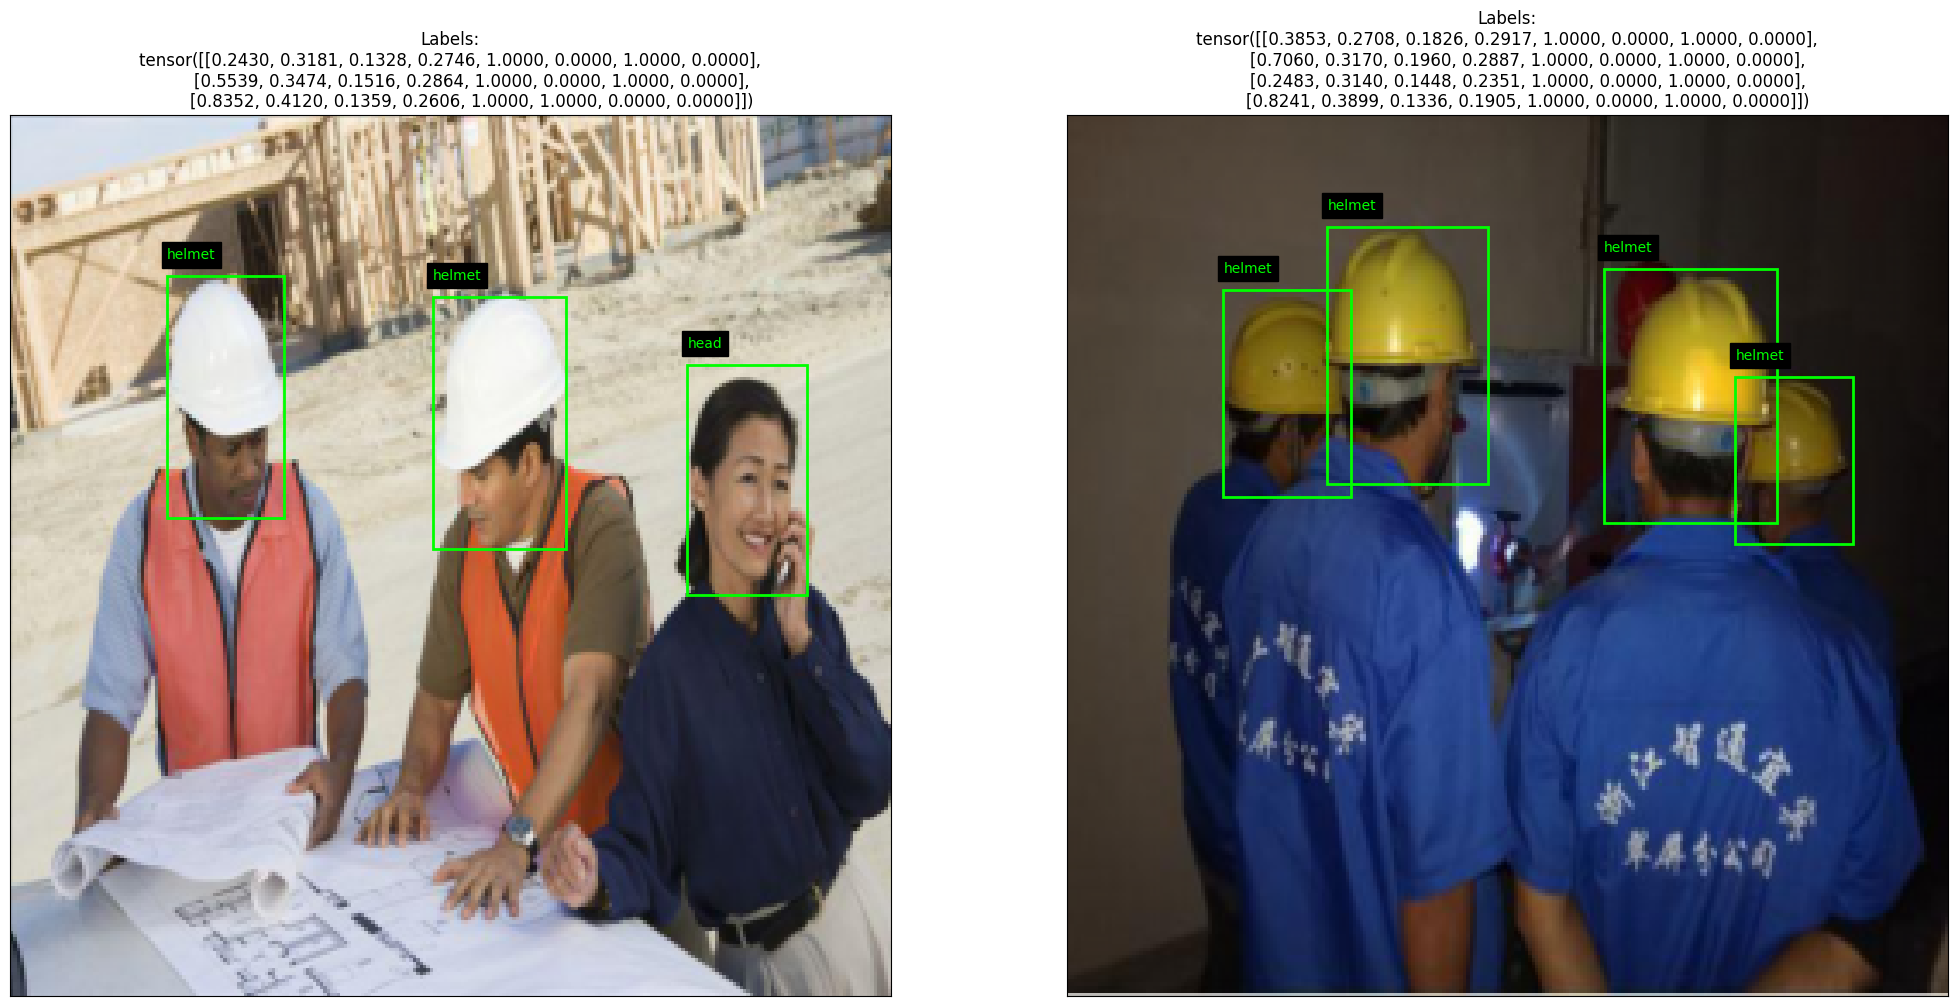

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)

#images, labels = dataiter.next() #python, torchvision version match issue
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 25))

# display 2 images
for idx in range(2):
    ax = fig.add_subplot(1, 2, idx+1, xticks=[], yticks=[])
    image_np = np.transpose(images[idx], (1, 2, 0))  # shape: (H, W, C)
    image_np = image_np * 0.5 + 0.5  # unnormalize
    ax.imshow(image_np)

    label = labels[idx]
    valid_labels = label[~(label == -1).all(dim=1)]
    draw_bounding_boxes(ax, valid_labels, img_size=(image_np.shape[0], image_np.shape[1]), class_names=CLASSES, is_prediction=False)

    # filter out padding (rows where all values are -1)

    
    valid_labels = label[~(label == -1).all(axis=1)]
    ax.set_title(f'Labels:\n{valid_labels}')

plt.show()


### View an Image in More Detail

Showing the normalized red, green, and blue (RGB) color channels as three separate, gray scale intensity images.

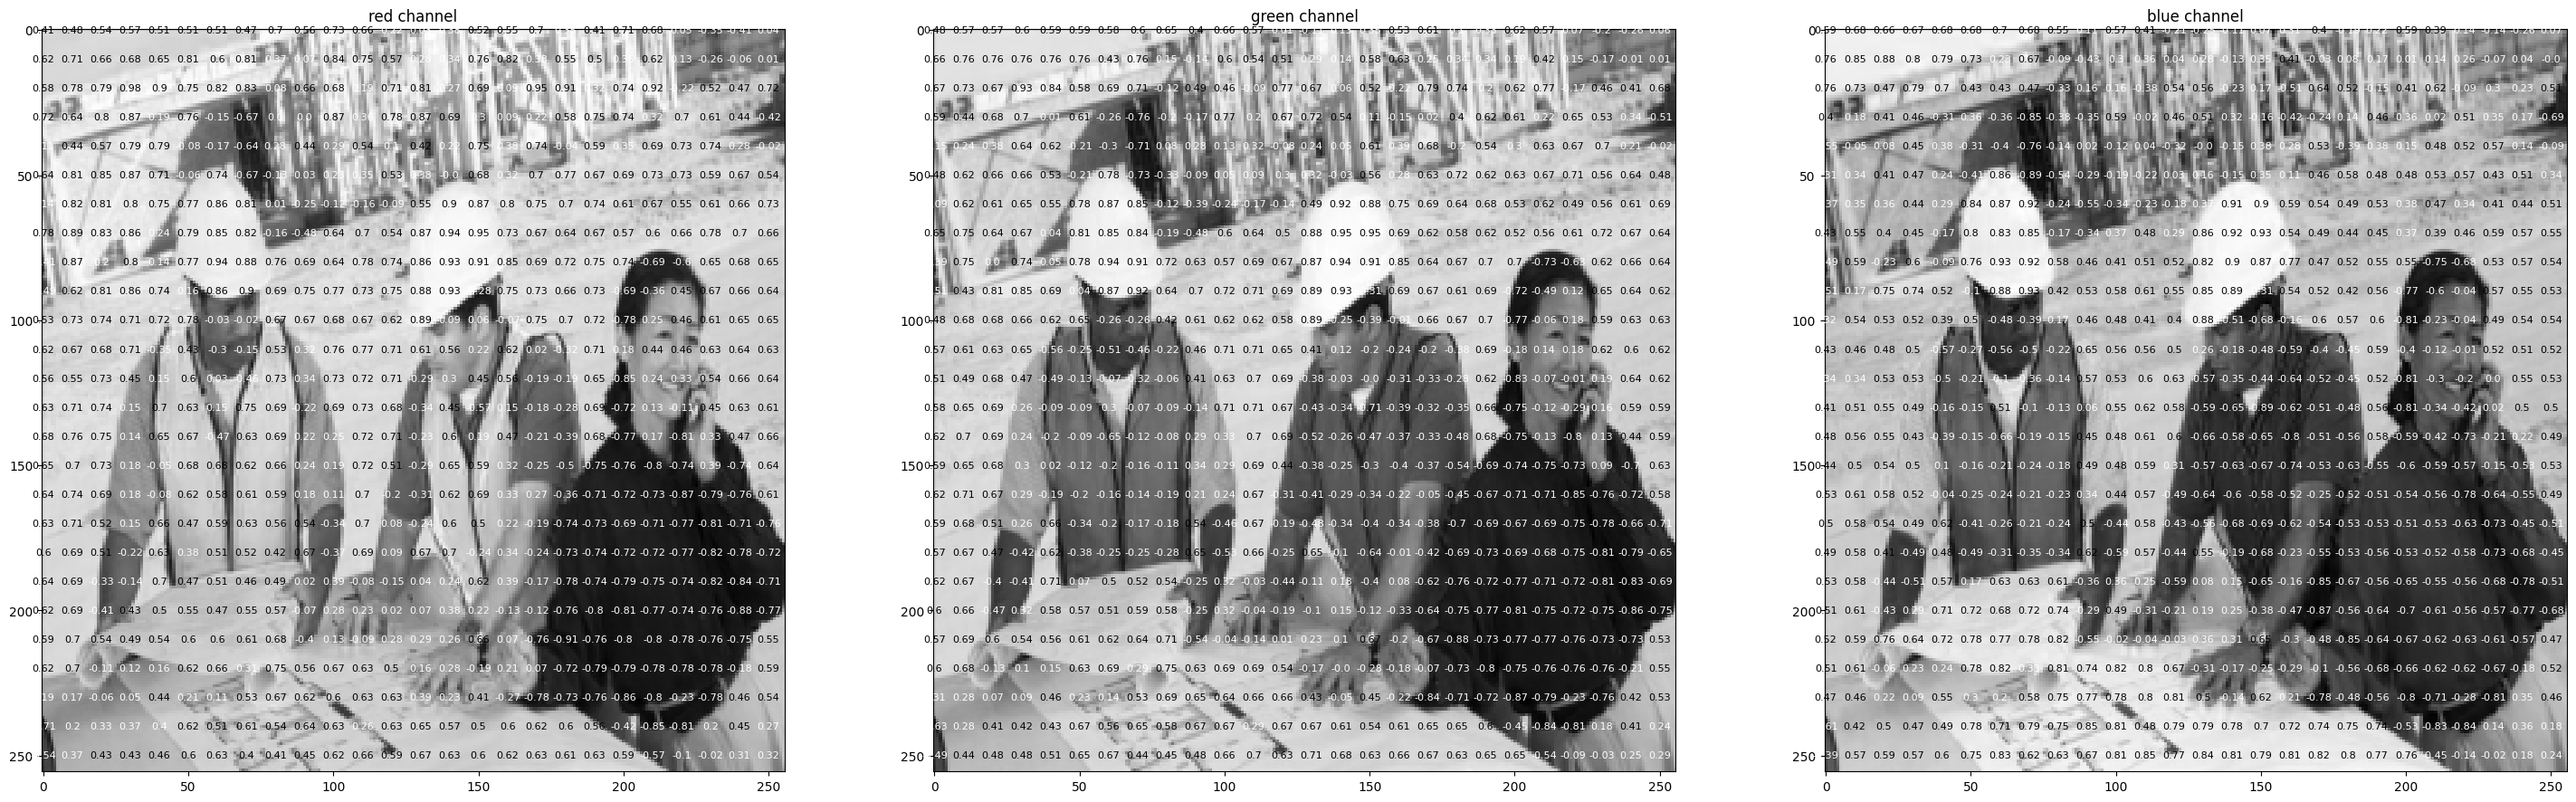

In [6]:
rgb_img = np.squeeze(images[0])
channels = ["red channel", "green channel", "blue channel"]
step = 10  # visualizing in steps of 10 pixels due to large image size

fig = plt.figure(figsize=(36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap="gray")
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max() / 2.5
    for x in range(0, width, step):
        for y in range(0, height, step):
            val = round(img[x][y], 2) if img[x][y] != 0 else 0
            ax.annotate(
                str(val),
                xy=(y, x),
                horizontalalignment="center",
                verticalalignment="center",
                size=8,
                color="white" if img[x][y] < thresh else "black",
            )

plt.show()

---
## Define the Network Architecture

In [7]:
import torch.nn as nn

# TOD: adjust the default values
NUMBER_ANCHORS = 3
GRID_SIZE = 7

class yolo(nn.Module):
    # TODO: adjust the default values
    def __init__(self, num_anchors=NUMBER_ANCHORS, grid_size=GRID_SIZE, NUM_CLASSES=NUM_CLASSES):
        super(yolo, self).__init__()

        self.num_anchors = num_anchors
        self.num_classes = NUM_CLASSES
        self.grid_size = grid_size

        self.convolution_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((self.grid_size, self.grid_size))
        )

        self.detection_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * grid_size * grid_size, grid_size * grid_size * num_anchors * (5 + NUM_CLASSES))
        )

    def forward(self, x):
        features = self.convolution_layers(x)
        predictions = self.detection_layers(features)
        predictions = predictions.view(-1, self.grid_size, self.grid_size, self.num_anchors, 5 + self.num_classes)

        # Clone before applying activations to avoid in-place modification issues during back probgation
        out = predictions.clone()

        out[..., 0:2] = torch.sigmoid(predictions[..., 0:2])                     # x, y
        out[..., 4]   = torch.sigmoid(predictions[..., 4])                       # objectness
        out[..., 2:4] = torch.sigmoid(predictions[..., 2:4])           # w, h
        out[..., 5:]  = torch.softmax(predictions[..., 5:], dim=-1)             # class probs

        return out



# create a complete CNN
model = yolo()
print(model)

# output total number of parameters
print(
    f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

yolo(
  (convolution_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AdaptiveAvgPool2d(output_size=(7, 7))
  )
  (detection_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12544, out_features=1176, bias=True)
  )
)
Total parameters: 15124632


---
## Specify Loss Function and Optimizer

### Create Custom Loss Function for YOLO

YOLO loss function is defined as following ([reference](https://www.geeksforgeeks.org/computer-vision/yolov3-from-scratch-using-pytorch/)):

![loss function](./images/yolo_loss_function.png)

In [8]:
# TODO: Need to adjust the default values
LAMBDA_COORD = 20.0
LAMBDA_OBJ = 20.0
LAMBDA_NOOBJ = 0.5
LAMBDA_CLASS = 1.0

def calculate_iou(pred, target):
    # pred and target are in [x_center, y_center, w, h]
    pred_x1 = pred[0] - pred[2] / 2
    pred_y1 = pred[1] - pred[3] / 2
    pred_x2 = pred[0] + pred[2] / 2
    pred_y2 = pred[1] + pred[3] / 2

    target_x1 = target[0] - target[2] / 2
    target_y1 = target[1] - target[3] / 2
    target_x2 = target[0] + target[2] / 2
    target_y2 = target[1] + target[3] / 2

    inter_x1 = torch.max(pred_x1, target_x1)
    inter_y1 = torch.max(pred_y1, target_y1)
    inter_x2 = torch.min(pred_x2, target_x2)
    inter_y2 = torch.min(pred_y2, target_y2)

    inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)
    pred_area = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
    target_area = (target_x2 - target_x1) * (target_y2 - target_y1)
    union = pred_area + target_area - inter_area

    # return inter_area / union.clamp(min=1e-6)
    return inter_area / (union + 1e-6)

def custom_loss(predictions, targets, anchors, confidence_threshold, iou_threshold, lambda_coord=LAMBDA_COORD, lambda_obj=LAMBDA_OBJ, lambda_noobj=LAMBDA_NOOBJ, lambda_class=LAMBDA_CLASS):
    batch_size, grid_height, grid_width, num_anchors, pred_len = predictions.shape
    device = predictions.device
    losses = []

    for i in range(batch_size):
        matched = []
        used_targets = set()
        pred = predictions[i]  # shape: [H, W, A, 5+C]
        target = targets[i]    # shape: [num_targets, 5+C]

        for target_i, target_box in enumerate(target):
            gx, gy = target_box[0], target_box[1]
            grid_x = int(gx * grid_width)
            grid_y = int(gy * grid_height)

            best_iou = 0
            best_anchor = -1

            for anchor_idx in range(num_anchors):
                pred_box = pred[grid_y, grid_x, anchor_idx]

                # Decode predicted box using anchors
                anchor_w, anchor_h = anchors[anchor_idx]
                px = torch.sigmoid(pred_box[0])
                py = torch.sigmoid(pred_box[1])
                pw = torch.exp(pred_box[2]) * anchor_w
                ph = torch.exp(pred_box[3]) * anchor_h
                pred_box_decoded = torch.tensor([px, py, pw, ph], device=device)

                iou = calculate_iou(pred_box_decoded, target_box[:4])
                if iou > best_iou:
                    best_iou = iou
                    best_anchor = anchor_idx

            if best_iou > iou_threshold and best_anchor != -1:
                matched.append((grid_y, grid_x, best_anchor, target_i))
                used_targets.add(target_i)

        for gy in range(grid_height):
            for gx in range(grid_width):
                for a in range(num_anchors):
                    pred_box = pred[gy, gx, a]
                    pred_conf = torch.sigmoid(pred_box[4])

                    match = next(((my, mx, ma, ti) for (my, mx, ma, ti) in matched if my == gy and mx == gx and ma == a), None)

                    if match:
                        _, _, _, target_i = match
                        target_box = target[target_i]

                        # Decode prediction
                        anchor_w, anchor_h = anchors[a]
                        px = torch.sigmoid(pred_box[0])
                        py = torch.sigmoid(pred_box[1])
                        pw = torch.exp(pred_box[2]) * anchor_w
                        ph = torch.exp(pred_box[3]) * anchor_h
                        pred_box_decoded = torch.stack([px, py, pw, ph])

                        # Coord loss (for tx, ty, tw, th)
                        box_loss = (
                            torch.nn.functional.mse_loss(px, target_box[0]) +
                            torch.nn.functional.mse_loss(py, target_box[1]) +
                            torch.nn.functional.mse_loss(torch.sqrt(pw + 1e-6), torch.sqrt(target_box[2] + 1e-6)) +
                            torch.nn.functional.mse_loss(torch.sqrt(ph + 1e-6), torch.sqrt(target_box[3] + 1e-6))
                        )

                        # Object loss
                        # iou_score = calculate_iou(pred_box_decoded, target_box[:4]).detach()
                        # obj_loss = torch.nn.functional.mse_loss(pred_conf, iou_score)
                        obj_loss = torch.nn.functional.mse_loss(pred_conf, torch.tensor(1.0, device=device))

                        # Class loss
                        class_loss = torch.nn.functional.binary_cross_entropy(torch.sigmoid(pred_box[5:]), target_box[5:])

                        # print(f"Loss breakdown - Box: {lambda_coord * box_loss:.4f}, Obj: {lambda_obj * obj_loss:.4f}, Class: {lambda_class * class_loss:.4f}")

                        losses.append(lambda_coord * box_loss + lambda_obj * obj_loss + lambda_class * class_loss)
                    else:
                        noobj_loss = torch.nn.functional.mse_loss(pred_conf, torch.tensor(0.0, device=device))
                        losses.append(lambda_noobj * noobj_loss)

    total_loss = torch.stack(losses).sum() / batch_size if losses else torch.tensor(0.0, device=device)
    if torch.is_grad_enabled():
        assert total_loss.requires_grad, "Loss does not require grad!"
    return total_loss

In [9]:
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

# specify loss function (categorical cross-entropy)
criterion = custom_loss

# specify optimizer
# TODO: adjust the learning rate
# smaller lr means it requires more epochs to improve
# larger lr means it may overshoot and become unstable
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.95)    # adding warmup and decay to the epochs to avoid overshooting

---
## Train the Network



### Variables Needed for Training

In [10]:
valid_loss_min = np.inf  # track change in validation loss
total_epochs_run = 0

# TODO: Need to adjust base on the anchor size
anchors = torch.tensor([
    [0.10, 0.15],  # Small object
    [0.20, 0.30],  # Medium object
    [0.40, 0.50]   # Larger object
], dtype=torch.float32)

### Can Run the Following Section as Many time as wanted

In [11]:
import time
from datetime import timedelta

start_time = time.time()

# TODO: update the following variable
n_epochs = 10   # number of epochs to run for this iteration
warmup_steps = 500  # number of batch steps before the learning rate is back to the base value
CONFIDENCE_THRESHOLD = 0.05
IOU_THRESHOLD = 0.05

global_step = total_epochs_run * len(train_loader)
base_lr = scheduler.get_last_lr()[0]

# load the model if this is a continuation of training
if total_epochs_run > 0:
    print(f"Continuing training from epoch {total_epochs_run + 1}")
    model.load_state_dict(torch.load("model_trained.pt", weights_only=True))

for epoch in range(1, n_epochs + 1):
    print(f"Epoch {total_epochs_run + epoch}/{total_epochs_run + n_epochs}")

    # TODO: adjust early and late thresholds
    if total_epochs_run + epoch > 5:
        CONFIDENCE_THRESHOLD = 0.15
        IOU_THRESHOLD = 0.15
    if total_epochs_run + epoch > 10:
        CONFIDENCE_THRESHOLD = 0.3
        IOU_THRESHOLD = 0.3

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    print("Training...")
    model.train()
    for batch_idx, (images, targets) in enumerate(train_loader):
        # add batch lerning rate warmup to the early batches to help with the stability of the training
        # Batch-level learning rate warmup using global step
        if global_step < warmup_steps:
            warmup_lr = base_lr * (global_step + 1) / warmup_steps
            for param_group in optimizer.param_groups:
                param_group['lr'] = warmup_lr
        else:
            # Reset to scheduler's LR if needed
            for param_group in optimizer.param_groups:
                param_group['lr'] = scheduler.get_last_lr()[0]

        global_step += 1

        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, targets = images.cuda(), targets.cuda()

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)

        # calculate the batch loss
        loss = criterion(output, targets, anchors, CONFIDENCE_THRESHOLD, IOU_THRESHOLD)

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward(retain_graph=True)
        # perform a single optimization step (parameter update)
        optimizer.step()

        # update training loss
        train_loss += loss.item() * images.size(0)

    ######################
    # validate the model #
    ######################
    print("Validating...")
    model.eval()
    for batch_idx, (images, targets) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, targets = images.cuda(), targets.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)

        # calculate the batch loss
        loss = criterion(output, targets, anchors, CONFIDENCE_THRESHOLD, IOU_THRESHOLD)

        # update average validation loss
        valid_loss += loss.item() * images.size(0)

    # calculate average losses
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

    # print training/validation statistics
    print(f"Training Loss: {train_loss}")
    print(f"Validation Loss: {valid_loss}")

    # save model if validation loss has decreased
    if valid_loss > 0 and valid_loss <= valid_loss_min:
        print(f"Validation loss has decreased from {valid_loss_min} to {valid_loss}")
        print("Saving model ...")
        torch.save(model.state_dict(), "model_trained.pt")
        valid_loss_min = valid_loss

    scheduler.step()
    print(f"Step Learning rate: {scheduler.get_last_lr()[0]:.6f}")
    print("\n")

total_epochs_run += n_epochs

end_time = time.time()
total_duration = end_time - start_time
print(f"Total Time for Training: {str(timedelta(seconds=int(total_duration)))}")

Epoch 1/10
Training...
Validating...
Training Loss: 30.659660034179687
Validation Loss: 28.502393112182617
Validation loss has decreased from inf to 28.502393112182617
Saving model ...
Step Learning rate: 0.000048


Epoch 2/10
Training...
Validating...
Training Loss: 27.190151977539063
Validation Loss: 26.93086410522461
Validation loss has decreased from 28.502393112182617 to 26.93086410522461
Saving model ...
Step Learning rate: 0.000095


Epoch 3/10
Training...
Validating...
Training Loss: 26.987352447509764
Validation Loss: 26.833024826049805
Validation loss has decreased from 26.93086410522461 to 26.833024826049805
Saving model ...
Step Learning rate: 0.000142


Epoch 4/10
Training...
Validating...
Training Loss: 26.827752304077148
Validation Loss: 26.473924102783204
Validation loss has decreased from 26.833024826049805 to 26.473924102783204
Saving model ...
Step Learning rate: 0.000190


Epoch 5/10
Training...
Validating...
Training Loss: 26.612402725219727
Validation Loss: 26.325

---
## Load the Model with the Lowest Validation Loss

In [12]:
model.load_state_dict(torch.load('model_trained.pt', weights_only=True))

<All keys matched successfully>

---
## Test the Trained Network

In [13]:
# track test loss
test_loss = 0.0
class_correct = [0. for _ in range(NUM_CLASSES)]
class_total = [0. for _ in range(NUM_CLASSES)]

# TODO: adjust TEST_CONFIDENCE_THRESHOLD and TEST_IOU_THRESHOLD
TEST_CONFIDENCE_THRESHOLD = CONFIDENCE_THRESHOLD
TEST_IOU_THRESHOLD = IOU_THRESHOLD
print("Testing with confidence threshold:", TEST_CONFIDENCE_THRESHOLD, "and IOU threshold:", TEST_IOU_THRESHOLD)

model.eval()
for batch_idx, (data, target) in enumerate(test_loader):
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    with torch.no_grad():
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target, anchors, TEST_CONFIDENCE_THRESHOLD, TEST_IOU_THRESHOLD)
        test_loss += loss.item() * data.size(0)

    batch_size = data.size(0)

    for b in range(batch_size):
        preds = output[b]       # shape: [batch_size, S, S, num_anchors, 5 + num_classes]
        labels = target[b]      # shape: [M, 5 + num_classes]

        labels = labels[labels[:, 0] != -1]  # remove padding
        preds = preds.view(-1, preds.shape[-1])
        # print("Sample pred after reshape:", preds[0])

        for gt in labels:
            gt_class = int(torch.argmax(gt[5:]).item())
            best_iou = 0
            best_pred_class = None

            assert preds.shape == (GRID_SIZE * GRID_SIZE * NUMBER_ANCHORS, 5 + NUM_CLASSES)
            for pred in preds:
                iou = calculate_iou(pred[:4], gt[1:5])
                if iou > best_iou:
                    best_iou = iou
                    best_pred_class = torch.argmax(pred[5:]).item()

            class_total[gt_class] += 1
            if best_iou > TEST_IOU_THRESHOLD:
                if best_pred_class == gt_class:
                    class_correct[gt_class] += 1

# average test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(NUM_CLASSES):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            CLASSES[i], 100 * class_correct[i] / class_total[i],
            class_correct[i], class_total[i]))
    else:
        print('Test Accuracy of %5s: N/A (no ground truth samples)' % (CLASSES[i]))

if sum(class_total) > 0:
    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * sum(class_correct) / sum(class_total),
        sum(class_correct), sum(class_total)))
else:
    print('\nTest Accuracy (Overall): N/A (no valid ground truth boxes in test set)')

Testing with confidence threshold: 0.15 and IOU threshold: 0.15
Test Loss: 21.447896

Test Accuracy of  head: 33% (603/1803)
Test Accuracy of helmet: 25% (1234/4863)
Test Accuracy of person: 28% (41/142)

Test Accuracy (Overall): 27% (1878/6808)


## Visualize Sample Test Results


### Non-Maximum Suppression Function

This is to remove redundant overlapping boxes that the predicted the same object

In [14]:
import torchvision.ops as ops

def apply_nms(predictions, iou_threshold=TEST_IOU_THRESHOLD, conf_threshold=TEST_CONFIDENCE_THRESHOLD):
    boxes = []
    scores = []
    class_ids = []

    for pred in predictions:
        conf = pred[4].item()
        if conf < conf_threshold:
            continue

        class_score, class_id = torch.max(pred[5:], dim=0)
        total_score = conf * class_score.item()

        if total_score < conf_threshold:
            continue

        x, y, w, h = pred[0:4]
        x1 = x - w / 2
        y1 = y - h / 2
        x2 = x + w / 2
        y2 = y + h / 2

        boxes.append([x1, y1, x2, y2])
        scores.append(total_score)
        class_ids.append(class_id.item())

    if not boxes:
        return torch.empty((0, 5 + predictions.shape[1] - 5))

    boxes = torch.tensor(boxes)
    scores = torch.tensor(scores)

    keep = ops.nms(boxes, scores, iou_threshold)
    filtered_preds = []

    for idx in keep:
        pred = predictions[idx].clone()
        pred[4] = scores[idx]  # overwrite with actual used score (conf class prob)
        filtered_preds.append(pred)
    
    return torch.stack(filtered_preds)


### Visualize Outputs

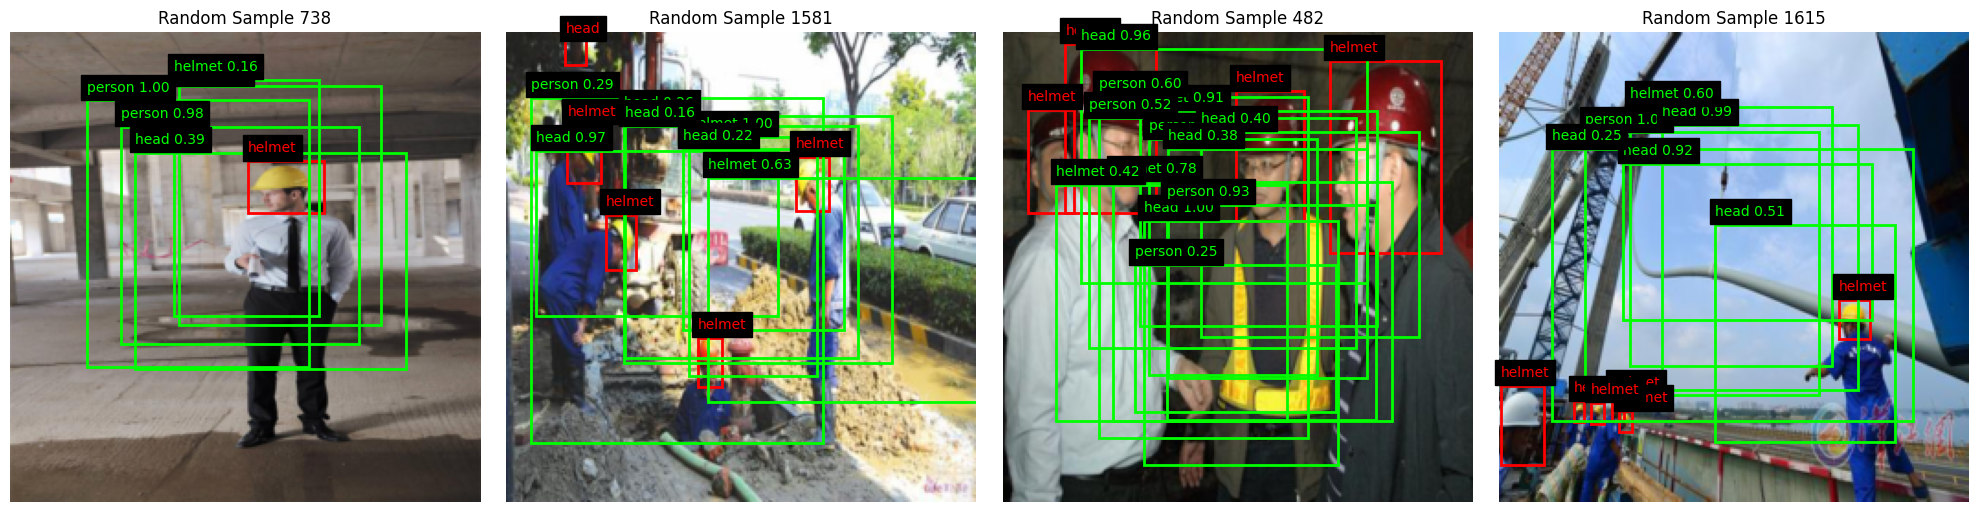

In [15]:
import matplotlib.pyplot as plt
import random

# Collect all test samples into memory for random access
all_images = []
all_targets = []

for images, targets in test_loader:
    all_images.extend(images)
    all_targets.extend(targets)

# Choose N random indices
N = 4
indices = random.sample(range(len(all_images)), k=N)

fig, axs = plt.subplots(1, N, figsize=(5 * N, 5))
if N == 1:
    axs = [axs]

model.eval()
for i, idx in enumerate(indices):
    image = all_images[idx].unsqueeze(0).to(next(model.parameters()).device)
    target = all_targets[idx].to(image.device)

    with torch.no_grad():
        output = model(image)[0].cpu()

    img = image[0].cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-5)
    ax = axs[i]
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Random Sample {idx}")

    # Draw predicted and ground truth boxes
    output = output.view(-1, output.shape[-1])
    output = apply_nms(output, iou_threshold=TEST_IOU_THRESHOLD, conf_threshold=TEST_CONFIDENCE_THRESHOLD)
    draw_bounding_boxes(ax, target.cpu(), img.shape[:2], CLASSES, color="red", is_prediction=False)
    draw_bounding_boxes(ax, output, img.shape[:2], CLASSES, color="lime", is_prediction=True)

plt.tight_layout()
plt.show()